In [2]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
width = u.Quantity(0.5, u.deg)
height = u.Quantity(0.5, u.deg)

coord = SkyCoord("0:26:49", "-71:32:10", unit=(u.hourangle, u.deg), frame='icrs')
Gaia.ROW_LIMIT = -1
data_Gaia = Gaia.query_object_async(coordinate=coord, width=width, height=height)

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
import pandas as pd
import numpy as np

cols = ['ra', 'dec', 'pmra', 'pmdec', 'dist', 'parallax']
data = pd.DataFrame()

for item in cols:
    data[item] = data_Gaia[item]
data = data.dropna()
data_np = pd.DataFrame(data).to_numpy()

In [4]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(data_np)
data_np = scaler.transform(data_np)

In [5]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN(algorithm='auto', metric='euclidean',
             min_cluster_size=100, min_samples=None)
hdb.fit(data_np)
hdb_labels = hdb.labels_
hdb_n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
hdb_n_noise = list(hdb_labels).count(-1)

print("Estimated number of clusters: %d" % hdb_n_clusters)
print("Estimated number of noise points: %d" % hdb_n_noise)

Estimated number of clusters: 2
Estimated number of noise points: 1675


In [6]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=3, min_samples=2).fit(data_np)
db_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
db_n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
db_n_noise = list(db_labels).count(-1)

print("Estimated number of clusters: %d" % db_n_clusters)
print("Estimated number of noise points: %d" % db_n_noise)


Estimated number of clusters: 2
Estimated number of noise points: 16


In [7]:
from sklearn import metrics
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(preference=-100, random_state=0).fit(data_np)
cluster_centers_indices = af.cluster_centers_indices_
af_labels = af.labels_
af_n_noise = list(af_labels).count(-1)

af_n_clusters = len(cluster_centers_indices)
print(f"Estimated number of clusters: {af_n_clusters}")
print(f'Estimated number of noise points: {af_n_noise}')


Estimated number of clusters: 24
Estimated number of noise points: 0


In [12]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means = KMeans(init="k-means++", n_clusters=2, n_init=10)
k_means.fit(data_np)

mbk = MiniBatchKMeans(init="k-means++", n_clusters=2,
                    n_init=10, max_no_improvement=10, verbose=0)
mbk.fit(data_np)

k_means_n_clusters = len(k_means.cluster_centers_)
k_means_cluster_centers = k_means.cluster_centers_

order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_n_clusters = len(mbk.cluster_centers_[order])
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(data_np, k_means_cluster_centers)
k_means_n_noise = list(k_means_labels).count(-1)

mbk_means_labels = pairwise_distances_argmin(data_np, mbk_means_cluster_centers)
mbk_means_n_noise = list(mbk_means_labels).count(-1)

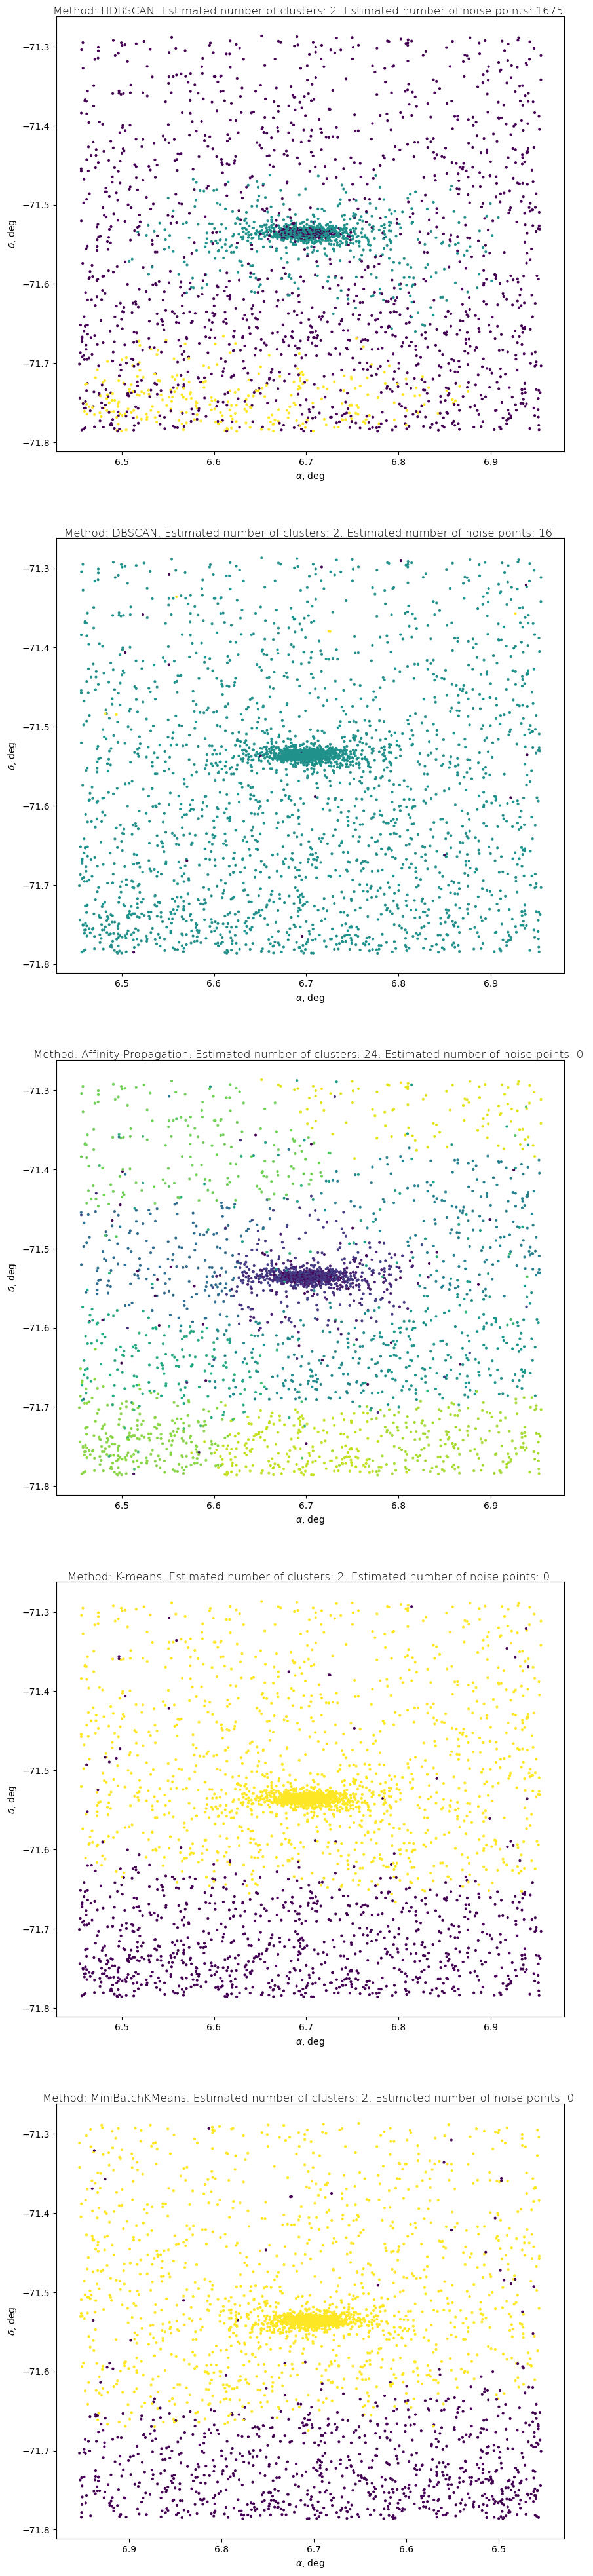

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

labels = [hdb_labels, db_labels, af_labels, k_means_labels, mbk_means_labels]
n_clusters = [hdb_n_clusters, db_n_clusters, af_n_clusters, k_means_n_clusters, mbk_means_n_clusters]
n_noise = [hdb_n_noise, db_n_noise, af_n_noise, k_means_n_noise, mbk_means_n_noise]
methods = ['HDBSCAN', 'DBSCAN', 'Affinity Propagation', 'K-means', 'MiniBatchKMeans']
fig, ax = plt.subplots(len(methods), 1, figsize=(10, len(methods)*10), sharey=True, squeeze=False)

for i in range(len(methods)):
    ax[i][0].set_xlabel(r"$\alpha$, deg")
    ax[i][0].set_ylabel(r"$\delta$, deg")
    ax[i][0].scatter(data["ra"], data["dec"], c=labels[i], s=4)
    plt.gca().invert_xaxis()
    ax[i][0].set_title(label=f'Method: {methods[i]}. Estimated number of clusters: {n_clusters[i]}. Estimated number of noise points: {n_noise[i]} ',
          fontweight=20,
          pad='2.0')
    plt.plot()
plt.savefig("figures/result_NGC121_scatter.svg")